<a href="https://colab.research.google.com/github/Pandaklez/masters-hse-proga/blob/master/nn_intro_torch_%D0%9A%D0%BB%D0%B5%D0%B7%D0%BE%D0%B2%D0%B8%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Эту тетрадку лучше запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [1]:
!pip install pandas scikit-learn gensim matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Для домашнего задания буду использовать задачу классификации с кворой, как и советуется по заданию

## Классификация

Данные возьмем из соревнования - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [4]:
quora = pd.read_csv('quora.csv')

In [5]:
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Предобработка точно такая же

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

273056

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

14083

In [11]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# поставит тоже 100
MAX_LEN = 100

In [14]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05, random_state=42)

Чтобы итерироваться по данным нужно создать вот такой класс, в котором будет функция \_\_get_item\_\_

В нее будет передавать индекс и мы можем задать вручную, что по этому индексу будет возвращаться  

В этот класс мы вставим предобработку, которую делали выше. Так мы сможем генерировать данные батчами и не грузить все целиком.

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.dataset = dataset[text_field].values
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        # таргеты можно сразу целиком выделить 
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем


        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)

        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


Разлчия в самой модели тоже минимальные - нужно поменять активацию в последнем слое, лосс и можно добавить метрику.

In [16]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

Как выбирать batch_size? Размер батча может влиять на качество модели и точно влияет на скорость обучения. Обычно, чем больше батч, тем быстрее будет обучаться модель. Размер батча ограничен памятью видеокарты, поэтому чем лучше gpu, тем больше может быть batch_size. 

Примерное максимальное значение можно найти быстрым перебором. Если появляется ошибка, то слишком большой batch_size, а если обучается, то можно попробовать поставить побольше.

## а) конкатенировать эмбединги в один большой эмбединг

In [17]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten() # вместо усреднения склеим все в 1 вектор
        self.fc = nn.Linear(embedding_dim*MAX_LEN, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() # активацию менять даже не пришлось, так как у нас бинарная классификация
                                # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = self.flatten(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

Немного перепишем функции тренировки и обучения, чтобы еще и accuracy посчитать

In [18]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        
        #лосс и еще и метрика теперь
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

Тут ниже я попробовала размер эмбеддингов заменить с 30 на 50, но от этого стало сильно дольше работать.

In [20]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 50, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [21]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.1776680957984638; Accuracy: 0.942262575075075
Loss: 0.16283486317796608; Accuracy: 0.9444233835667833
Loss: 0.15411014943847898; Accuracy: 0.9461304809936646
Loss: 0.14870309289968678; Accuracy: 0.947175270380095
1
Loss: 0.12321026386829229; Accuracy: 0.954247215965966
Loss: 0.12386080913204679; Accuracy: 0.953357538144072
Loss: 0.12315019203841229; Accuracy: 0.953346427975992
Loss: 0.12282461221403228; Accuracy: 0.9533467351212803
2
Loss: 0.11709755341390948; Accuracy: 0.9561553741241241
Loss: 0.11786802789161896; Accuracy: 0.9553077319909955
Loss: 0.11773928019822777; Accuracy: 0.9551217593364455
Loss: 0.11764931901041106; Accuracy: 0.955051262815704


это тоже нормальный график, но тут acc должна расти

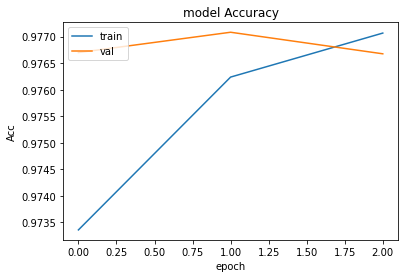

In [22]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

Можно вытащить предикты и посчитать все через sklearn

In [24]:
from sklearn.metrics import classification_report

In [25]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     61365
         1.0       0.73      0.38      0.50      3942

    accuracy                           0.95     65307
   macro avg       0.85      0.68      0.74     65307
weighted avg       0.95      0.95      0.95     65307



Короче на размере 50 вместо 30 качество ухудшилось, а время работы увеличилось. Вернем 30 и будем сравнивать другие тактики работы с эмбеддингами с версией на 30

In [26]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [27]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.18039031715334594; Accuracy: 0.9420005943443444
Loss: 0.16629926323995045; Accuracy: 0.9435928901950975
Loss: 0.1569733071703341; Accuracy: 0.9452825420973658
Loss: 0.15120126987139296; Accuracy: 0.9464328972868217
1
Loss: 0.12405947840831301; Accuracy: 0.9540321571571572
Loss: 0.12448091128875519; Accuracy: 0.9533634004502252
Loss: 0.12364630627831884; Accuracy: 0.9533373103534512
Loss: 0.12317286178685778; Accuracy: 0.9533027788197049
2
Loss: 0.11723728281808449; Accuracy: 0.9560889014014013
Loss: 0.11817095800675172; Accuracy: 0.9552373843171585
Loss: 0.11800534734903037; Accuracy: 0.9550253730410136
Loss: 0.1178776206298228; Accuracy: 0.9549350228182045


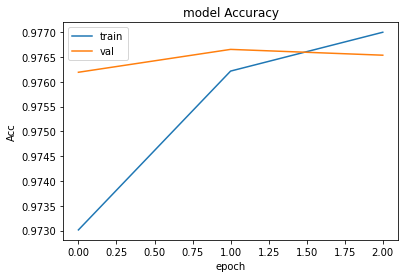

In [28]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [43]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     61365
         1.0       0.65      0.57      0.61      3942

    accuracy                           0.96     65307
   macro avg       0.81      0.78      0.79     65307
weighted avg       0.95      0.96      0.95     65307



## б) усреднять эмбединги

In [44]:
class Clf_2(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()  # активацию менять даже не пришлось, так как у нас бинарная классификация
                                 # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        hidden = torch.mean(embedded, dim=1)  # усредняем вектора последовательности
        dense_outputs = self.fc(hidden)  # пропускаем через полносвязный слой 

        outputs = self.act(dense_outputs)
        
        return outputs

In [47]:
model = Clf_2(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [48]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.22006118522063867; Accuracy: 0.9397522522522522
Loss: 0.20636133884656066; Accuracy: 0.9391629408454227
Loss: 0.1922101230199395; Accuracy: 0.9399852034011337
Loss: 0.18219525115315274; Accuracy: 0.9410868342085521
1
Loss: 0.1395137432563651; Accuracy: 0.9489919607107107
Loss: 0.1387148842237901; Accuracy: 0.9484957322411206
Loss: 0.13727002935350519; Accuracy: 0.9487224908302767
Loss: 0.1361669961639749; Accuracy: 0.9489393832833208
2
Loss: 0.12757987094608633; Accuracy: 0.9521943818818819
Loss: 0.12801836437921693; Accuracy: 0.9515421773386693
Loss: 0.12756969293168918; Accuracy: 0.9515606764754918
Loss: 0.12726595363514248; Accuracy: 0.9515796917979494


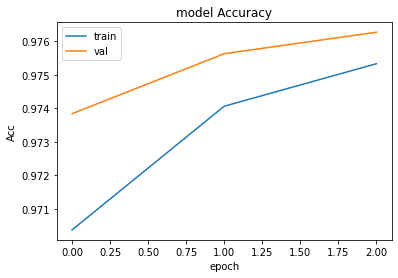

In [49]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Как будто хуже обучается, чем когда скленные вектора. Типа рост на графике заметно медленнее. И финальный лосс больше.

In [50]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [56]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     61365
         1.0       0.58      0.62      0.60      3942

    accuracy                           0.95     65307
   macro avg       0.78      0.80      0.79     65307
weighted avg       0.95      0.95      0.95     65307



## в) складывать эмбединги

In [57]:
class Clf_3(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()  # активацию менять даже не пришлось, так как у нас бинарная классификация
                                 # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        hidden = torch.sum(embedded, dim=1)  # складываем вектора последовательности
        dense_outputs = self.fc(hidden)  # пропускаем через полносвязный слой 

        outputs = self.act(dense_outputs)
        
        return outputs

In [58]:
model = Clf_3(len(word2id), 30, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [59]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.2678946533703708; Accuracy: 0.9363230417917918
Loss: 0.21507213521131938; Accuracy: 0.9400930934217109
Loss: 0.19261047066813233; Accuracy: 0.9425316251250416
Loss: 0.17943333448838908; Accuracy: 0.9441667057389347
1
Loss: 0.13009940340622766; Accuracy: 0.952906031031031
Loss: 0.13045532754871653; Accuracy: 0.9522124343421711
Loss: 0.12995415801886082; Accuracy: 0.9520530280926975
Loss: 0.1292557249194564; Accuracy: 0.9522019176669168
2
Loss: 0.12375891634129786; Accuracy: 0.9547555367867868
Loss: 0.1248984352469802; Accuracy: 0.9537561749624812
Loss: 0.12487489219087886; Accuracy: 0.9534975200066689
Loss: 0.12459089453386855; Accuracy: 0.9535176762940735


Получается, что это чуть лучше, чем усреднять эмбеддинги, но всё еще хуже, чем склеивать в один большой.

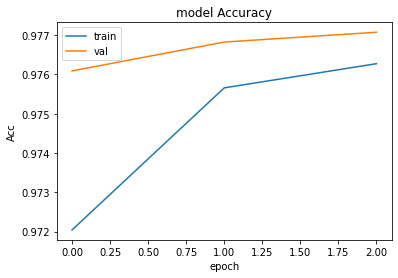

In [60]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [62]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     61365
         1.0       0.53      0.72      0.61      3942

    accuracy                           0.94     65307
   macro avg       0.75      0.84      0.79     65307
weighted avg       0.95      0.94      0.95     65307



# сразу две предобученные эмбединг модели

Значит, эмбеддинги стоит еще и зафиксировать, чтобы они потом в процессе обучения самой нейронки не разошлись.

In [63]:
import gensim

Обучаю фастекст модель:

In [64]:
texts = quora.sample(frac=0.1).question_text.apply(preprocess).tolist()

In [69]:
%%time
ft_1 = gensim.models.FastText(texts, size=100, iter=10)

CPU times: user 1min 37s, sys: 445 ms, total: 1min 37s
Wall time: 53.3 s


In [78]:
# проверяю что вектора обучились
ft_1.wv.most_similar('learn')[0][0]

'learnt'

In [83]:
weights_1 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    
    try:
        weights_1[i] = ft_1.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights_1[i] = ft_1.wv['ajpjmpzcv']

In [75]:
%%time
w2v_2 = gensim.models.Word2Vec(texts, size=100, iter=10, min_count=3)

CPU times: user 37 s, sys: 295 ms, total: 37.3 s
Wall time: 22.5 s


In [76]:
# проверяю что вектора обучились
w2v_2.wv.most_similar('learn')

[('study', 0.7026283740997314),
 ('learning', 0.6870408058166504),
 ('read', 0.6677531003952026),
 ('teach', 0.6672182679176331),
 ('programming', 0.6544222831726074),
 ('understand', 0.6402304172515869),
 ('practice', 0.6335183382034302),
 ('publish', 0.6226884126663208),
 ('approach', 0.6184325218200684),
 ('speak', 0.6051572561264038)]

In [86]:
weights_2 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights_2[i] = w2v_2.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights_2[i] = w2v_2.wv['']

Теперь создаю нейронку:

In [111]:
class Clf_4(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, embeddings_weights_1, embeddings_weights_2, output_dim):
        
        super().__init__()          
        self.embedding_1 = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_1.from_pretrained(torch.tensor(embeddings_weights_1), freeze=True)
        
        self.embedding_2 = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_2.from_pretrained(torch.tensor(embeddings_weights_2), freeze=True)

        self.fc = nn.Linear(2 * embedding_dim, output_dim)
        self.act = nn.Sigmoid()  # активацию менять даже не пришлось, так как у нас бинарная классификация
                                 # если классов больше 2, то нужно поставить nn.Softmax()
        
    def forward(self, text):
        
        embedded_1 = self.embedding_1(text)
        embedded_2 = self.embedding_2(text)
        hidden_1 = torch.mean(embedded_1, dim=1)  # усредняем вектора последовательности
        hidden_2 = torch.mean(embedded_2, dim=1)  # усредняем вектора последовательности
        hidden = torch.cat((hidden_1, hidden_2), dim=1)

        dense_outputs = self.fc(hidden)  # пропускаем через полносвязный слой 

        outputs = self.act(dense_outputs)
        
        return outputs

In [112]:
model = Clf_4(len(word2id), 100, weights_1, weights_2, 1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() # другой лосс - Binary cross-entropy

model = model.to(device)
criterion = criterion.to(device)

In [113]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.21435540126966643; Accuracy: 0.9380747935435435
Loss: 0.19051751737418088; Accuracy: 0.9398527388694348
Loss: 0.17625402944878604; Accuracy: 0.9417683498666222
Loss: 0.16718523003296962; Accuracy: 0.9432651131532883
1
Loss: 0.1298579182792772; Accuracy: 0.9518385573073073
Loss: 0.12962184758999457; Accuracy: 0.951286189969985
Loss: 0.12873911111925831; Accuracy: 0.9514004668222741
Loss: 0.1280933731664312; Accuracy: 0.9514282867591898
2
Loss: 0.12188042552621516; Accuracy: 0.9541611924424425
Loss: 0.12247269206669642; Accuracy: 0.9534552432466233
Loss: 0.12225767714445016; Accuracy: 0.9533659657385796
Loss: 0.12210754344249612; Accuracy: 0.9533262221805452


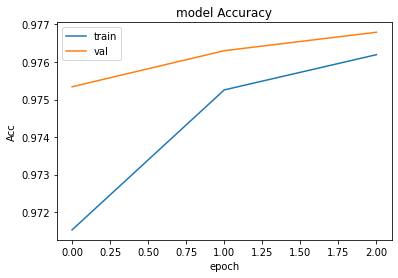

In [114]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [116]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     61365
         1.0       0.60      0.62      0.61      3942

    accuracy                           0.95     65307
   macro avg       0.79      0.80      0.79     65307
weighted avg       0.95      0.95      0.95     65307

